<a href="https://colab.research.google.com/github/Xubwei/NLP_Bert/blob/main/%E5%BB%A3%E5%91%8A%E6%96%87%E7%AF%A9%E9%81%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install transformers

In [ ]:
import os
import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from transformers import DistilBertTokenizer
from transformers import DistilBertModel
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForSequenceClassification

import time
import warnings
warnings.filterwarnings('ignore')

### Step 1. 資料前處理
**廣告文為：0；留言(非廣告文)為：1**

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/BENQ專案/v5/BENQ標記資料_Final.csv")

In [ ]:
df['result'] = df['result'].astype('category')
df['result'] = df['result'].map({0.0: 1, 1.0: 0})
df = df.dropna()

In [ ]:
df.head(5)

,content,result
0,I was so happy tonight. My wife said I had a n...,1
1,usb port stopped working\n from one day to an...,1
2,Over priced\n In darkness it's a great pictur...,1
3,Outstanding like being in a theater!\n I boug...,1
4,"The best projector ever, read on??\n Solid co...",1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9889 entries, 0 to 9910
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   content  9889 non-null   object  
 1   result   9889 non-null   category
dtypes: category(1), object(1)
memory usage: 164.3+ KB


In [ ]:
total_counts = df['result'].value_counts().sum()
percentage = df['result'].value_counts()[0] / total_counts
print(df['result'].value_counts())
print("==================")
print("廣告文比例：{:.2f}%".format(percentage * 100))

0    6544
1    3345
Name: result, dtype: int64
廣告文比例：66.17%


### Step 2 處理資料集
**training set:70%, validation set:10%, test set:20%**

In [ ]:
from sklearn.model_selection import train_test_split
x = df.iloc[:, 0].values
y = df.iloc[:, 1].values
train_texts, test_texts, train_labels, test_labels = train_test_split(x, y, test_size=0.2, random_state=42)
train_texts, valid_texts, train_labels, valid_labels = train_test_split(train_texts, train_labels, test_size=0.125, random_state=42)

**Tokenization**

In [ ]:
PRE_TRAINED_MODEL_NAME = 'distilbert-base-cased'
tokenizer = DistilBertTokenizerFast.from_pretrained(PRE_TRAINED_MODEL_NAME)

BATCH_SIZE = 16
EPOCHS = 10
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
DEVICE

device(type='cuda')

In [ ]:
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
valid_encodings = tokenizer(list(valid_texts), truncation=True, padding=True)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True)

In [ ]:
class ContentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels, texts):
        self.encodings = encodings
        self.labels = labels
        self.texts = texts # 為了查看預測後的內容
        self.label_map = { 0 : 0, 1 : 1}

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} #根據索引"idx"從"encodings"和"labels"中獲取數據，並將它們轉換成PyTorch張量。
        item['labels'] = torch.tensor(self.label_map[self.labels[idx]])
        item['content'] = self.texts[idx]  # 添加原始的 content 內容(為了查看預測後的內容)
        return item

    def __len__(self):
        return len(self.labels)


In [ ]:
train_dataset = ContentDataset(train_encodings, train_labels, train_texts)
valid_dataset = ContentDataset(valid_encodings, valid_labels, valid_texts)
test_dataset = ContentDataset(test_encodings, test_labels, test_texts)

In [ ]:
# 這段程式碼創建了用於訓練、驗證和測試的資料載入器（DataLoader）
# 它們用於將資料集分成小批次（batch）以供模型進行訓練和預測。
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Step 3 載入模型

In [ ]:
# 創建一個DistilBERT模型的實例，專門用於序列分類任務
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
model.to(DEVICE)
model.train() # 將模型設置為訓練模式
# 建一個Adam優化器用於更新模型的權重參數。優化器將使用學習率為5e-5的Adam算法來執行這一任務
optim = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-3)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.

### Step 4 訓練模型

**compute_accuracy 函數：**

這個函數的目的是計算模型在給定數據加載器（可以是訓練數據、驗證數據或測試數據）上的準確度。準確度是正確預測的樣本數量與總樣本數量的比例。為了計算準確度，我們需要：

- 將每批數據（包括 input_ids、attention_mask 和 labels）送入模型。
- 從模型的輸出中獲得預測標籤（這是通過找到 logits 的最大值來完成的）。
- 比較預測標籤與真實標籤，計算正確預測的數量。

請注意，我們在這個函數中使用 torch.no_grad() 確保在計算準確度時不會計算梯度，這可以節省計算資源

In [ ]:
def compute_accuracy(model, data_loader, device):

    with torch.no_grad(): # 在計算準確度時確保不會計算梯度，以節省記憶體和計算資源
        correct_pred, num_examples = 0, 0

        for batch_idx, batch in enumerate(data_loader):

            ### Prepare data
            input_ids = batch['input_ids'].to(device ) # 當前批次中提取 input_ids
            attention_mask = batch['attention_mask'].to(device) # 當前批次中提取 attention_mask
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss, logits = outputs['loss'], outputs['logits'] # 從模型輸出中提取損失和 logits（未經激活函數的輸出）
            _, predicted_labels = torch.max(logits, 1)  # 使用 torch.max 找到 logits 中的最大值，以獲得模型的預測標籤 (通過找到logits中的最大值，可以確定模型預測的類別)

            num_examples += labels.size(0)
            correct_pred += (predicted_labels == labels).sum()
    return correct_pred.float()/num_examples * 100

In [ ]:
start_time = time.time()

comparison_df = pd.DataFrame(columns=['True Labels', 'Predicted Labels']) #創建real y vs pred y 的表格
best_valid_accuracy = 0.0 # 初始化最佳驗證準確度

for epoch in range(EPOCHS):

    model.train()
    for batch_idx, batch in enumerate(train_loader): # 遍歷每個批次的數據。每個批次包含一小部分的訓練數據

        ### Prepare data
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        ### Forward
        # 將數據傳遞給模型，執行前向傳播，並獲取輸出
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss, logits = outputs['loss'], outputs['logits']

        ### Backward
        optim.zero_grad()
        loss.backward()
        optim.step()

        ### Logging
        if not batch_idx % 250:
            print (f'Epoch: {epoch+1:04d}/{EPOCHS:04d} | '
                f'Batch {batch_idx:04d}/{len(train_loader):04d} | '
                f'Loss: {loss:.4f}')
    model.eval()

    with torch.set_grad_enabled(False):
        train_accuracy = compute_accuracy(model, train_loader, DEVICE)
        valid_accuracy = compute_accuracy(model, valid_loader, DEVICE)
        print(f'training accuracy: {train_accuracy:.2f}%')
        print(f'valid accuracy: {valid_accuracy:.2f}%')

        # 為比較表格添加數據
        for batch_idx, batch in enumerate(valid_loader):
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)
            content = batch['content']  # 新增：取得X的內容
            outputs = model(input_ids, attention_mask=attention_mask)
            _, predicted_labels = torch.max(outputs['logits'], 1)

            # 新增：將X的內容、真實值Y和預測值Y添加到comparison_df中
            for i in range(len(content)):
                comparison_df = comparison_df.append({
                    'Content': content[i],
                    'True Labels': labels[i].item(),
                    'Predicted Labels': predicted_labels[i].item()
                }, ignore_index=True)


        # 檢查是否需要保存模型
        if valid_accuracy > best_valid_accuracy:
            best_valid_accuracy = valid_accuracy
            torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/BENQ專案/v5/model_best_v5.pt')
            print(f'Saved new best model with accuracy: {best_valid_accuracy:.2f}%')


    print(f'Time elapsed: {(time.time() - start_time)/60:.2f} min')
    print("=================================================")

print(f'Total Training Time: {(time.time() - start_time)/60:.2f} min')
print(f'Test accuracy: {compute_accuracy(model, test_loader, DEVICE):.2f}%')


Epoch: 0001/0010 | Batch 0000/0433 | Loss: 0.7047
Epoch: 0001/0010 | Batch 0250/0433 | Loss: 0.1714
training accuracy: 93.60%
valid accuracy: 92.52%
Saved new best model with accuracy: 92.52%
Time elapsed: 7.68 min
Epoch: 0002/0010 | Batch 0000/0433 | Loss: 0.2459
Epoch: 0002/0010 | Batch 0250/0433 | Loss: 0.3644
training accuracy: 94.09%
valid accuracy: 91.20%
Time elapsed: 15.33 min
Epoch: 0003/0010 | Batch 0000/0433 | Loss: 0.0497
Epoch: 0003/0010 | Batch 0250/0433 | Loss: 0.2379
training accuracy: 95.06%
valid accuracy: 90.80%
Time elapsed: 22.98 min
Epoch: 0004/0010 | Batch 0000/0433 | Loss: 0.3689
Epoch: 0004/0010 | Batch 0250/0433 | Loss: 0.0622
training accuracy: 96.36%
valid accuracy: 91.20%
Time elapsed: 30.62 min
Epoch: 0005/0010 | Batch 0000/0433 | Loss: 0.3709
Epoch: 0005/0010 | Batch 0250/0433 | Loss: 0.1383
training accuracy: 96.61%
valid accuracy: 90.60%
Time elapsed: 38.25 min
Epoch: 0006/0010 | Batch 0000/0433 | Loss: 0.0437
Epoch: 0006/0010 | Batch 0250/0433 | Loss: 

In [ ]:
# # 在訓練結束後，保存模型
# torch.save(model, '/content/drive/MyDrive/Colab Notebooks/BENQ專案/v5/model_v5.pt')

### Step 5 檢查成果

In [ ]:
comparison_df

,True Labels,Predicted Labels,Content
0,1,1,[USA-CT] [H] Oculus Quest 2 64GB w/ Anker char...
1,0,0,"Outdoor Projector, Anker NEBULA Solar Portable..."
2,1,1,"elitedesk 800 g4 sound issue, help?"
3,1,1,Can't stream from hardly any streaming service...
4,0,1,flow3rkap - is this not a dream? [Ambient/elec...
...,...,...,...
9885,0,0,"2pcs Car Door Logo & Led Light No drilling, no..."
9886,0,0,"48% Off Native 1080P WiFi Bluetooth Projector,..."
9887,1,1,[USA-NY][H] LG CineBeam HU85LA 4k HDR Laser Ul...
9888,0,0,[Amazon] Native 1080P 5G WiFi Bluetooth Projec...


In [ ]:
# save_path = '/content/drive/MyDrive/Colab Notebooks/BENQ專案/v5/valid預測結果_v5.csv'

# # 將 DataFrame 寫入 CSV 文件
# comparison_df.to_csv(save_path, index=False)

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, log_loss, accuracy_score, precision_score, recall_score
import numpy as np

def evaluate_model(model, data_loader, device):
    model.eval()
    all_labels = []
    all_predictions = []
    all_probabilities = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probabilities = torch.nn.functional.softmax(logits, dim=-1)
            _, predicted_labels = torch.max(logits, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted_labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)
    all_probabilities = np.array(all_probabilities)

    # 計算混淆矩陣
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    # 計算 F1-score
    f1 = f1_score(all_labels, all_predictions)

    # 計算 Log Loss
    logloss = log_loss(all_labels, all_probabilities)

    # 計算 Accuracy
    accuracy = accuracy_score(all_labels, all_predictions)

    # 計算 Precision
    precision = precision_score(all_labels, all_predictions)

    # 計算 Recall
    recall = recall_score(all_labels, all_predictions)

    return conf_matrix, f1, logloss, accuracy, precision, recall

# 在訓練結束後，用測試數據集來評估模型
conf_matrix, f1, logloss, accuracy, precision, recall = evaluate_model(model, test_loader, DEVICE)

print(f'Confusion Matrix:\n {conf_matrix}')
print('--------------------')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print('--------------------')
print(f'F1 Score: {f1:.4f}')
print(f'Log Loss: {logloss:.4f}')

Confusion Matrix:
 [[1197  108]
 [  46  627]]
--------------------
Accuracy: 0.9221
Precision: 0.8531
Recall: 0.9316
--------------------
F1 Score: 0.8906
Log Loss: 0.3320


## **測試結果**

載入模型

In [ ]:
from transformers import DistilBertForSequenceClassification
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 建立模型
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
model = model.to(device)

# 載入模型權重
state_dict = torch.load('/content/drive/MyDrive/Colab Notebooks/BENQ專案/v5/model_best_v5.pt')
model.load_state_dict(state_dict)

model.eval()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

### 1. 看 非廣告的機率
將logits 透過softmax轉換為機率

疑慮：模型本身是比較廣告文vs留言的logits大小，所以用softmax轉換為機率來做不太OK

In [ ]:
import pandas as pd
import torch
from transformers import DistilBertTokenizerFast

# 載入tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# 定義一個函數，該函數接受一段文本，並返回該文本為非廣告的機率
def get_prob_non_ad(text):
    inputs = tokenizer(text, truncation=True, padding=True, return_tensors='pt')
    inputs = {name: tensor.to(device) for name, tensor in inputs.items()}

    outputs = model(**inputs)
    scores = outputs.logits

    # 將原始的分數通過softmax函數轉換為機率。
    probs = torch.nn.functional.softmax(scores, dim=-1)

    # 將預測結果的機率從GPU取出來並轉換為numpy array，並取第一個元素的第二個值，這裡是代表「非廣告文」的機率。
    prob_non_ad = probs.detach().to('cpu').numpy()[0,1]

    return prob_non_ad

# 為DataFrame的每一行增加一個新的欄位
comparison_df_prob = comparison_df.copy()
comparison_df_prob['prob_non_ad'] = comparison_df_prob['Content'].apply(get_prob_non_ad)

In [ ]:
comparison_df_prob.head(5)

,True Labels,Predicted Labels,Content,prob_non_ad
0,1,1,[USA-CT] [H] Oculus Quest 2 64GB w/ Anker char...,0.512769
1,0,0,"Outdoor Projector, Anker NEBULA Solar Portable...",0.551987
2,1,1,"elitedesk 800 g4 sound issue, help?",0.875252
3,1,1,Can't stream from hardly any streaming service...,0.282426
4,0,1,flow3rkap - is this not a dream? [Ambient/elec...,0.187901


In [ ]:
# save_path = '/content/drive/MyDrive/Colab Notebooks/BENQ專案/v5/prob_結果_v5.csv'

# # 將 DataFrame 寫入 CSV 文件
# comparison_df_prob.to_csv(save_path, index=False)

### 使用模型預測標籤

In [ ]:
import time

# Prepare the data
PRE_TRAINED_MODEL_NAME = 'distilbert-base-cased'
tokenizer = DistilBertTokenizerFast.from_pretrained(PRE_TRAINED_MODEL_NAME)
texts = comparison_df_prob['Content'].tolist() # 這裡暫時放 comparison_df_prob
encodings = tokenizer(texts, truncation=True, padding=True)
input_ids = torch.tensor(encodings['input_ids'])
attention_mask = torch.tensor(encodings['attention_mask'])

# Split the data into batches
batch_size = 50  # Adjust as needed
input_batches = torch.split(input_ids, batch_size)
attention_mask_batches = torch.split(attention_mask, batch_size)

# Make the predictions
predictions = []
for i, (input_batch, attention_mask_batch) in enumerate(zip(input_batches, attention_mask_batches)):
    start_time = time.time()  # Get the start time
    with torch.no_grad():
        outputs = model(input_batch.to(device), attention_mask=attention_mask_batch.to(device))
        _, batch_predictions = torch.max(outputs['logits'], 1)
        predictions.extend(batch_predictions.cpu().numpy())
    end_time = time.time()  # Get the end time
    print(f"Batch {i+1} of {len(input_batches)}: Time taken: {end_time - start_time:.2f} seconds")  # Print the time taken

# Print the predictions

comparison_df_prob['prediction_model'] = predictions
print(comparison_df_prob)

Batch 1 of 198: Time taken: 0.76 seconds
Batch 2 of 198: Time taken: 0.74 seconds
Batch 3 of 198: Time taken: 0.74 seconds
Batch 4 of 198: Time taken: 0.72 seconds
Batch 5 of 198: Time taken: 0.73 seconds
Batch 6 of 198: Time taken: 0.73 seconds
Batch 7 of 198: Time taken: 0.73 seconds
Batch 8 of 198: Time taken: 0.72 seconds
Batch 9 of 198: Time taken: 0.73 seconds
Batch 10 of 198: Time taken: 0.73 seconds
Batch 11 of 198: Time taken: 0.73 seconds
Batch 12 of 198: Time taken: 0.73 seconds
Batch 13 of 198: Time taken: 0.73 seconds
Batch 14 of 198: Time taken: 0.73 seconds
Batch 15 of 198: Time taken: 0.73 seconds
Batch 16 of 198: Time taken: 0.74 seconds
Batch 17 of 198: Time taken: 0.74 seconds
Batch 18 of 198: Time taken: 0.74 seconds
Batch 19 of 198: Time taken: 0.74 seconds
Batch 20 of 198: Time taken: 0.73 seconds
Batch 21 of 198: Time taken: 0.74 seconds
Batch 22 of 198: Time taken: 0.74 seconds
Batch 23 of 198: Time taken: 0.73 seconds
Batch 24 of 198: Time taken: 0.74 seconds
B

In [ ]:
comparison_df_prob

,True Labels,Predicted Labels,Content,prob_non_ad,predicted_logits_v1,prediction_model
0,1,1,[USA-CT] [H] Oculus Quest 2 64GB w/ Anker char...,0.512769,1,1
1,0,0,"Outdoor Projector, Anker NEBULA Solar Portable...",0.551987,0,0
2,1,1,"elitedesk 800 g4 sound issue, help?",0.875252,1,1
3,1,1,Can't stream from hardly any streaming service...,0.282426,1,1
4,0,1,flow3rkap - is this not a dream? [Ambient/elec...,0.187901,1,1
...,...,...,...,...,...,...
9885,0,0,"2pcs Car Door Logo & Led Light No drilling, no...",0.174889,0,0
9886,0,0,"48% Off Native 1080P WiFi Bluetooth Projector,...",0.524050,0,0
9887,1,1,[USA-NY][H] LG CineBeam HU85LA 4k HDR Laser Ul...,0.530396,1,1
9888,0,0,[Amazon] Native 1080P 5G WiFi Bluetooth Projec...,0.696169,0,0


In [ ]:
# save_path = '/content/drive/MyDrive/Colab Notebooks/BENQ專案/v5/綜合測試結果_v5.csv'

# # 將 DataFrame 寫入 CSV 文件
# comparison_df_prob.to_csv(save_path, index=False)

### 嘗試直接使用 logits 看


In [ ]:
# Initialize the tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')

# Iterate over the content in the CSV file and make predictions
predictions = []
for content in comparison_df_prob['Content']: # 這裡暫時放 comparison_df_prob
    # Encode the content
    encoded_input = tokenizer(content, truncation=True, padding=True, return_tensors='pt')
    encoded_input = encoded_input.to('cuda' if torch.cuda.is_available() else 'cpu')

    # Make a prediction
    with torch.no_grad():
        outputs = model(**encoded_input)
        logits = outputs.logits

        # Get the predicted label
        _, predicted_label = torch.max(logits, dim=1)
        predictions.append(predicted_label.item())

# Add the predictions to the DataFrame
comparison_df_prob['predicted_logits_v1'] = predictions
comparison_df_prob.head()


,True Labels,Predicted Labels,Content,prob_non_ad,predicted_logits_v1
0,1,1,[USA-CT] [H] Oculus Quest 2 64GB w/ Anker char...,0.512769,1
1,0,0,"Outdoor Projector, Anker NEBULA Solar Portable...",0.551987,0
2,1,1,"elitedesk 800 g4 sound issue, help?",0.875252,1
3,1,1,Can't stream from hardly any streaming service...,0.282426,1
4,0,1,flow3rkap - is this not a dream? [Ambient/elec...,0.187901,1


In [ ]:
# save_path = '/content/drive/MyDrive/Colab Notebooks/BENQ專案/v5/logits_結果_v5.csv'

# # 將 DataFrame 寫入 CSV 文件
# comparison_df_prob.to_csv(save_path, index=False)

In [ ]:
comparison_df_prob['predicted_logits_v1'].describe()

count    9890.000000
mean        0.320526
std         0.466702
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: predicted_logits_v1, dtype: float64

## 三種預測方法的評估

In [ ]:
df = comparison_df_prob.copy()
df['True Labels']=df['True Labels'].astype(int)
df.head()

,True Labels,Predicted Labels,Content,prob_non_ad,predicted_logits_v1,prediction_model
0,1,1,[USA-CT] [H] Oculus Quest 2 64GB w/ Anker char...,0.512769,1,1
1,0,0,"Outdoor Projector, Anker NEBULA Solar Portable...",0.551987,0,0
2,1,1,"elitedesk 800 g4 sound issue, help?",0.875252,1,1
3,1,1,Can't stream from hardly any streaming service...,0.282426,1,1
4,0,1,flow3rkap - is this not a dream? [Ambient/elec...,0.187901,1,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9890 entries, 0 to 9889
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   True Labels          9890 non-null   object 
 1   Predicted Labels     9890 non-null   object 
 2   Content              9890 non-null   object 
 3   prob_non_ad          9890 non-null   float32
 4   predicted_logits_v1  9890 non-null   int64  
 5   prediction_model     9890 non-null   int64  
dtypes: float32(1), int64(2), object(3)
memory usage: 425.1+ KB


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import numpy as np

# Create a dictionary to store the results
results = {}

# Calculate metrics for each prediction method
for method in ['prob_non_ad', 'predicted_logits_v1', 'prediction_model']:
    if method == 'prob_non_ad':
        # Use 0.5 as the threshold
        predictions = np.where(df[method] >= 0.5, 1, 0)
    else:
        predictions = df[method]

    accuracy = accuracy_score(df['True Labels'], predictions)
    precision = precision_score(df['True Labels'], predictions)
    recall = recall_score(df['True Labels'], predictions)
    f1 = f1_score(df['True Labels'], predictions)

    results[method] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [ ]:
# Convert the results dictionary to a dataframe
results_df = pd.DataFrame(results).T

# Display the results dataframe
results_df

,accuracy,precision,recall,f1
prob_non_ad,0.429727,0.327422,0.771704,0.459770
predicted_logits_v1,0.925177,0.873817,0.890675,0.882166
prediction_model,0.925177,0.873817,0.890675,0.882166


### predicted_logits_v1

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
new_predictions = (df['predicted_logits_v1']).astype(int)
# Compute new accuracy
new_accuracy = accuracy_score(df['True Labels'], new_predictions)
# Compute new confusion matrix
new_confusion_mat = confusion_matrix(df['True Labels'], new_predictions)
# Compute new classification report
new_class_report = classification_report(df['True Labels'], new_predictions)
print(new_accuracy)
print("=================")
print(new_confusion_mat)
print("=================")
print(new_class_report)

0.9251769464105156
[[6380  400]
 [ 340 2770]]
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      6780
           1       0.87      0.89      0.88      3110

    accuracy                           0.93      9890
   macro avg       0.91      0.92      0.91      9890
weighted avg       0.93      0.93      0.93      9890



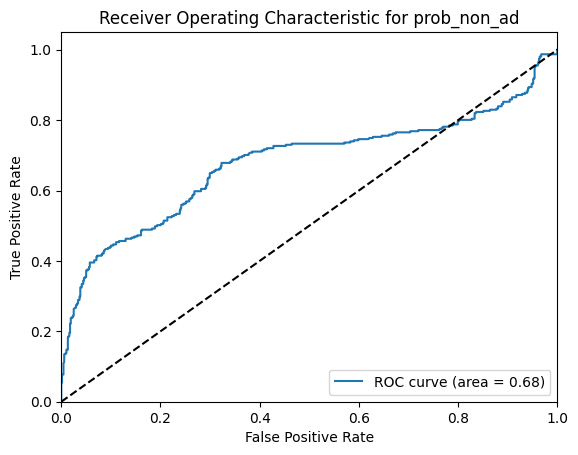

In [ ]:
import matplotlib.pyplot as plt
# Calculate ROC AUC for 'prob_non_ad'
fpr, tpr, thresholds = roc_curve(df['True Labels'], df['prob_non_ad'])
roc_auc = roc_auc_score(df['True Labels'], df['prob_non_ad'])

# Add ROC AUC to the results
results['prob_non_ad']['roc_auc'] = roc_auc

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for prob_non_ad')
plt.legend(loc="lower right")
plt.show()